In [43]:
from sparse_generalization.envs.box_world.env import BoxWorldEnv
from sparse_generalization.envs.box_world.wrappers import make_env
import gymnasium as gym
import torch
from sparse_generalization.models.transformer import MHABlock
from sparse_generalization.layers.bern_mha import MultiHeadAttentionBern
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

gym.register('BoxWorldEnv-v1', BoxWorldEnv)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\garga\Documents\Uni\Thesis\sparse-generalization\.venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment BoxWorldEnv-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [7]:
print(os.getcwd())

c:\Users\garga\Documents\Uni\Thesis\sparse-generalization\notebooks


In [21]:
class ModelWrapper(torch.nn.Module):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = MHABlock(
            embed_size=3, 
            out_dim=1, 
            hidden_dims=[64, 128, 64], 
            use_grid=True,
            model_dim=64, 
            num_feature_layers=3,
            num_heads=1, 
            residual=False, 
            positional_encoding=True, 
            mha_layer=MultiHeadAttentionBern,
            noisy_bern=False, 
            dropout=0.0, 
            act=torch.nn.ReLU, 
        )
        
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        out, attn = self.model(x)
        return self.sigmoid(out), attn
    
model = ModelWrapper()
model.model.load_state_dict(torch.load('../checkpoints/bern_mha_bw_1000_lagn_seed0.pt', weights_only=True))    
model.eval()

ModelWrapper(
  (model): MHABlock(
    (feature_map): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (7): ReLU()
    )
    (mha): MultiHeadAttentionBern(
      (dropout): Dropout(p=0.0, inplace=False)
      (queries): Linear(in_features=66, out_features=66, bias=True)
      (keys): Linear(in_features=66, out_features=66, bias=True)
      (values): Linear(in_features=66, out_features=66, bias=True)
      (projection): Linear(in_features=66, out_features=66, bias=True)
    )
    (mlp): BasicMLP(
      (layers): Sequential(
        (0): Linear(in_features=66, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): ReLU()
        (4): Dropout(p=0.0, inplace=

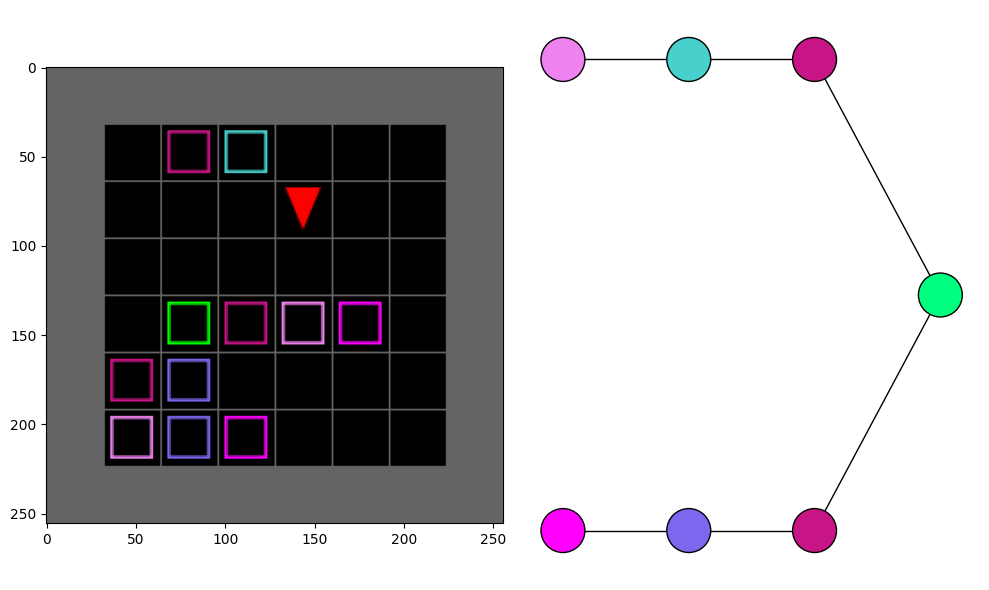

In [62]:
env = make_env(unsolvable_prob=0.0, size=8, num_pairs=3)
obs, _ = env.reset()
img = env.get_wrapper_attr('render_graph')()

In [63]:
obs_torch = torch.from_numpy(obs).view(1, 8, 8, 3).float()
out, attn = model(obs_torch)
goal_mask = obs[:, :, 0] == 8
coords = np.argwhere(goal_mask)
x, y = coords[0]
goal_index = y * 8 + x
out.item(), goal_index

(0.9020420908927917, np.int64(34))

In [87]:
attn[36]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)

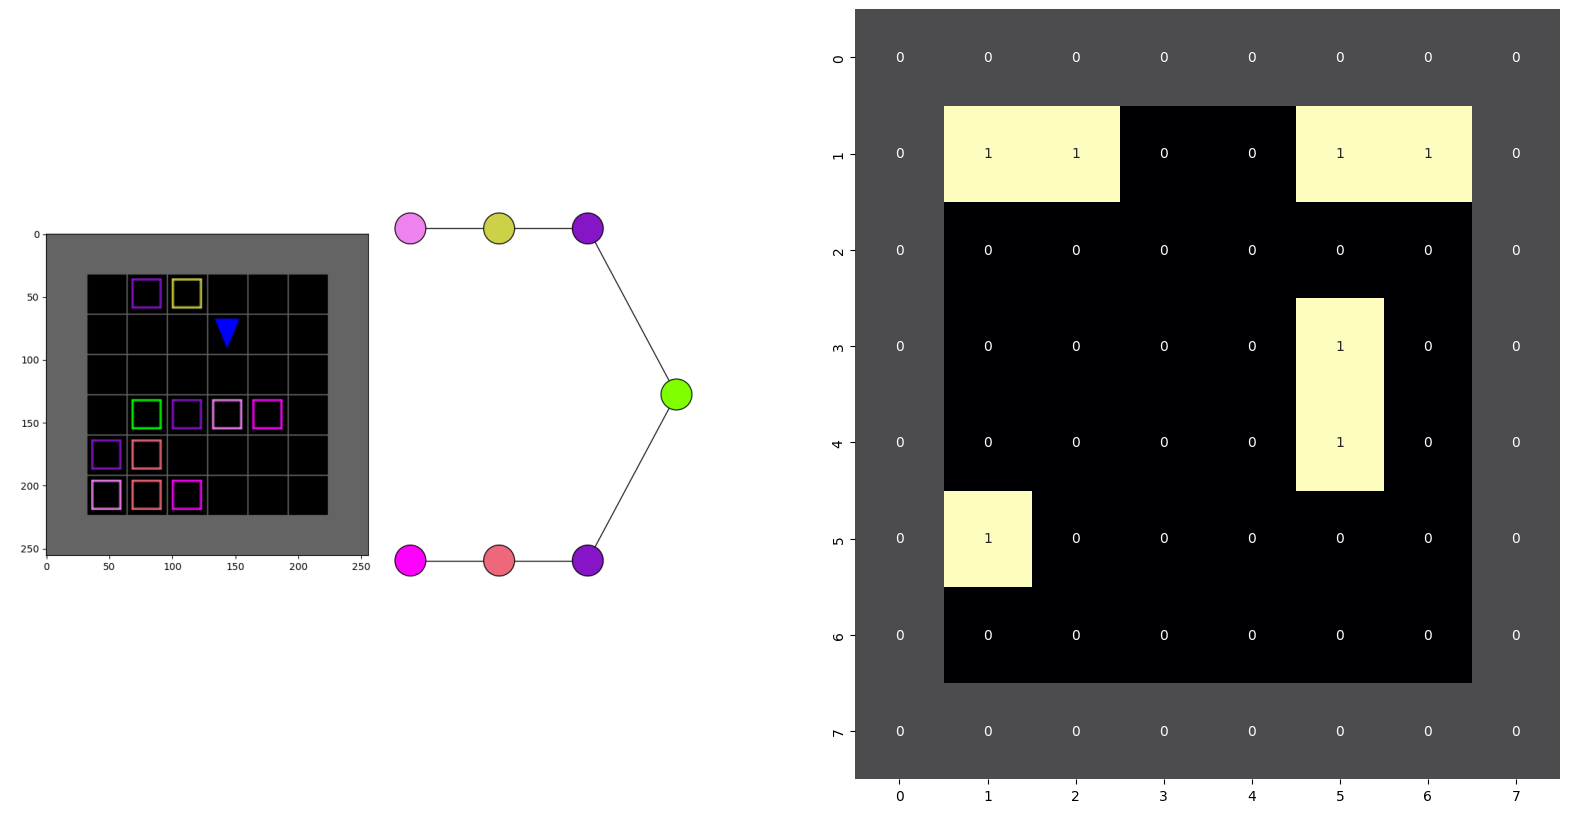

In [91]:
attn = attn.squeeze()
goal_adjs = attn[36, :].view(8, 8).detach().numpy()

colors = np.full((8, 8), np.nan, dtype=float)
colors[0, :] = 0
colors[-1, :] = 0
colors[:, 0] = 0
colors[:, -1] = 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(img)
ax[0].axis('off')

sns.heatmap(
    goal_adjs,
    cmap='magma',
    cbar=False,
    annot=goal_adjs,
    ax=ax[1],
)
overlay_cmap = sns.color_palette(["grey", "red", "lime"])
sns.heatmap(
    colors,
    cmap=overlay_cmap,
    mask=np.isnan(colors),
    cbar=False,
    alpha=0.6,
    ax=ax[1]
);

